In [1]:
#%load_ext autoreload
#%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pprint
from tqdm import tqdm
%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.size'] = 15

In [2]:
import pickle

def save(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
def load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def plot(results, **kwargs):
    results = dict(results)
    legend = kwargs.get('legend', True)
    y1lim = kwargs.get('y1lim')
    y2lim = kwargs.get('y2lim')
    xticks = kwargs.get('xticks')
    smooth = kwargs.get('smooth', 0)
    
    ax1 = plt.gca()
    for loss in 'cce_loss dicefg_loss dice_loss'.split():
        y = results[loss]
        if smooth:
            assert smooth % 2 == 0
            pad = int(smooth/2)
            pad_y = []
            pad_y.extend([y[0]]*pad)
            pad_y.extend(y)
            pad_y.extend([y[-1]]*pad)
            y = np.convolve(pad_y, np.ones((smooth+1,))/(smooth+1), mode='valid')
        ax1.plot(range(len(y)), y, label=loss[:-5])
    ax1.set_xlabel('iteration')

    if legend:
        ax1.legend(loc='center right')
    if y1lim:
        ax1.set_ylim(y1lim[0], y1lim[1])
    if kwargs.get('y1axis', True):
        ax1.set_ylabel('loss')        
    else:
        ax1.yaxis.set_ticklabels([])
    
    ax2 = ax1.twinx()
    ax2.grid()
    x = [x for x,v in results['accuracy']]
    acc = [v for x,v in results['accuracy']]
    ax2.plot(x, acc, 'k', label='accuracy')
    if y2lim:
        ax2.set_ylim(y2lim[0], y2lim[1])
    if kwargs.get('y2axis', True):
        ax2.set_ylabel('accuracy')
    else:
        ax2.yaxis.set_ticklabels([])
    if legend:
        ax2.legend(loc='upper right')
    if xticks:
        plt.xticks(xticks)
    plt.title(kwargs.get('title', ''))
    
def plot_grad(results, **kwargs):
    smooth = kwargs.get('smooth', 0)

    for grad in 'cce_grad dicefg_grad dice_grad'.split():
        y = results[grad]
        if smooth:
            assert smooth % 2 == 0
            pad = int(smooth/2)
            pad_y = []
            pad_y.extend([y[0]]*pad)
            pad_y.extend(y)
            pad_y.extend([y[-1]]*pad)
            y = np.convolve(pad_y, np.ones((smooth+1,))/(smooth+1), mode='valid')
        plt.plot(range(len(y)), y, label=grad)
    if kwargs.get('legend', True):
        plt.legend()
    if kwargs.get('xaxis', True):
        plt.xlabel('iteration')
    else:
        plt.gca().xaxis.set_ticklabels([])
    if kwargs.get('yaxis', True):
        plt.ylabel('global gradient norm')
    else:
        plt.gca().yaxis.set_ticklabels([])
    plt.title(kwargs.get('title', ''))
    plt.gca().grid(axis='y')
    ylim = kwargs.get('ylim')
    if ylim:
        plt.gca().set_ylim(ylim[0], ylim[1])

In [3]:
from main import experiment
from conv_net import ConvNet, TrainLoss, Optimizer

def run_experiments(threshold, optimizer, batch_norm=False, runs=5, n_conv=2, batch_size=2, iterations=10001):
    for train_loss in TrainLoss:
        for i in range(runs):
            result = experiment(threshold, iterations, train_loss, n_conv, optimizer, batch_size=batch_size, batch_norm=batch_norm)
            save(result, get_filename(train_loss, optimizer, threshold, n_conv, batch_size, batch_norm, i))
        
def get_filename(train_loss, optimizer, threshold, n_conv, batch_size, batch_norm, run_index):
    fg_percentage = int(100 * (1 - threshold))
    name = '_'.join([train_loss.value, optimizer.value, 'nconv%d' % n_conv, 'bs%d' % batch_size, 'bn%s' % str(batch_norm)])
    return './results/{}_{:d}fg_run{:d}.pkl'.format(name, fg_percentage, run_index)

/Users/gchlebus/anaconda2/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
for optimizer in Optimizer:
    for batch_norm in [True, False]:
        for thresh in [0.05, 0.5, 0.95]:
            run_experiments(thresh, optimizer, batch_norm, runs=3)

  0%|          | 0/10001 [00:00<?, ?it/s]

train_loss: DICEFG optimizer: ADAM n_conv: 2 batch_norm: False batch_size: 2 learning_rate: 0.001
Class distribution bg: 5% fg: 95%


100%|██████████| 10001/10001 [01:00<00:00, 165.64it/s]


Best accuracy 0.95 at iteration 250.


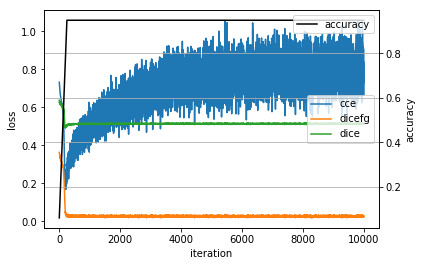

In [4]:
result = experiment(0.05, 10001, TrainLoss.DICEFG, 2, Optimizer.ADAM, 2, False)
plot(result)

### Group Plots

In [ ]:
def group_plot(threshold, optimizer, n_conv, batch_size, batch_norm, opts1, opts2, run_index=0):
    filenames = [get_filename(train_loss, optimizer, threshold, n_conv, batch_size, batch_norm, run_index) for train_loss in TrainLoss]
    titles = [train_loss.value for train_loss in TrainLoss]
    nrows = 2
    ncols = len(filenames)
    
    plt.figure()
    name = ''.join([optimizer.value, ', Batch Norm: %s' % str(batch_norm)])
    fg_percentage = int(round((1-threshold) * 100))
    plt.suptitle('{:d}% Foreground (run {:d})\n{}'.format(fg_percentage, run_index+1, name))
    plt.subplot(nrows, ncols, 1)
    plot_grad(load(filenames[0]), **opts1, title=titles[0])
    for i in range(1, ncols-1):
        plt.subplot(nrows, ncols, i+1)
        plot_grad(load(filenames[i]), **opts1, yaxis=False, title=titles[i])
    plt.subplot(nrows, ncols, ncols)
    plot_grad(load(filenames[-1]), **opts1, yaxis=False, title=titles[-1])
    
    plt.subplot(nrows, ncols, ncols+1)
    plot(load(filenames[0]), **opts2, y2axis=False, legend=False)
    for i in range(1, ncols-1):
        plt.subplot(nrows, ncols, ncols+i+1)
        plot(load(filenames[i]), **opts2, y1axis=False, y2axis=False, legend=False)
    plt.subplot(nrows, ncols, 2*ncols)
    plot(load(filenames[-1]), **opts2, y1axis=False)
    name = '-'.join([optimizer.value, 'nconv%d' % n_conv, 'batchsize%d' % batch_size, 'batchnorm%s' % str(batch_norm)])
    plt.savefig('../../assets/dice-cce-loss-function/{}_{:d}fg_run{:d}.png'.format(name, fg_percentage, run_index))
    
    
smooth1 = 200
smooth2 = 10

In [ ]:
opts1 = {
    'smooth': smooth1,
    'ylim': [0, 4],
    'legend': False,
    'xaxis': False
}
opts2 = {
    'smooth': smooth2,
    'y1lim': [0, 1],
    'y2lim': [0.9, 1.012],
}

for optimizer in Optimizer:
    for batch_norm in [True, False]:
        for thresh in [0.05, 0.5, 0.95]:
            for i in range(3):
                group_plot(thresh, optimizer, 2, 2, batch_norm, opts1, opts2, run_index=i)


In [ ]:
opts1 = {
    'smooth': smooth1,
    'ylim': [0, 2],
    'legend': False,
    'xaxis': False
}
opts2 = {
    'smooth': smooth2,
    'y1lim': [0, 1],
    'y2lim': [0, 1.02],
}
group_plot(0.8, opts1, opts2, title='20% FOREGROUND')
#plt.savefig('../../assets/dice-cce-loss-function/20fg.png')

In [ ]:
opts1 = {
    'smooth': smooth1,
    'ylim': [0, 5.5],
    'legend': False,
    'xaxis': False
}
opts2 = {
    'smooth': smooth2,
    'y1lim': [0, 3.5],
    'y2lim': [0, 1.02],
}
group_plot(0.2, opts1, opts2, title='80% FOREGROUND')
#plt.savefig('../../assets/dice-cce-loss-function/80fg.png')